# 第9章: クラスタリングとコミュニティ検出

## 学習目標
- クラスタリング係数を理解する
- コミュニティ検出アルゴリズムを習得する
- モジュラリティの概念を学ぶ
- 実データでコミュニティ分析ができる

## 難易度: 上級

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import japanize_matplotlib
plt.rcParams['font.sans-serif'] = ['IPAexGothic'] + plt.rcParams['font.sans-serif']
import numpy as np
from networkx.algorithms import community
%matplotlib inline

---
## 9.1 クラスタリング係数

In [2]:
G = nx.karate_club_graph()

# 局所クラスタリング係数
clustering = nx.clustering(G)

print("=== 局所クラスタリング係数 TOP10 ===")
top_clustering = sorted(clustering.items(), key=lambda x: x[1], reverse=True)[:10]
for node, coef in top_clustering:
    print(f"  ノード {node}: {coef:.4f}")

=== 局所クラスタリング係数 TOP10 ===
  ノード 7: 1.0000
  ノード 12: 1.0000
  ノード 14: 1.0000
  ノード 15: 1.0000
  ノード 16: 1.0000
  ノード 17: 1.0000
  ノード 18: 1.0000
  ノード 20: 1.0000
  ノード 21: 1.0000
  ノード 22: 1.0000


In [3]:
# グラフ全体の統計
avg_clustering = nx.average_clustering(G)
transitivity = nx.transitivity(G)

print(f"\n平均クラスタリング係数: {avg_clustering:.4f}")
print(f"推移性（グローバルクラスタリング係数）: {transitivity:.4f}")


平均クラスタリング係数: 0.5706
推移性（グローバルクラスタリング係数）: 0.2557


In [4]:
# 三角形の数
triangles = nx.triangles(G)
total_triangles = sum(triangles.values()) // 3
print(f"三角形の総数: {total_triangles}")

三角形の総数: 45


---
## 9.2 コミュニティ検出

コミュニティ = 内部は密に接続、外部とは疎に接続されたノード群

### 9.2.1 Louvain法

In [5]:
# Louvain法
communities_louvain = community.louvain_communities(G, seed=42)

print(f"=== Louvain法 ===")
print(f"検出されたコミュニティ数: {len(communities_louvain)}")
for i, comm in enumerate(communities_louvain):
    print(f"  コミュニティ{i+1}: {sorted(comm)} ({len(comm)}ノード)")

=== Louvain法 ===
検出されたコミュニティ数: 4
  コミュニティ1: [1, 2, 3, 7, 12, 13] (6ノード)
  コミュニティ2: [0, 4, 5, 6, 10, 11, 16, 17, 19, 21] (10ノード)
  コミュニティ3: [24, 25, 28, 31] (4ノード)
  コミュニティ4: [8, 9, 14, 15, 18, 20, 22, 23, 26, 27, 29, 30, 32, 33] (14ノード)


In [6]:
# モジュラリティの計算
modularity = community.modularity(G, communities_louvain)
print(f"\nモジュラリティ: {modularity:.4f}")


モジュラリティ: 0.4266


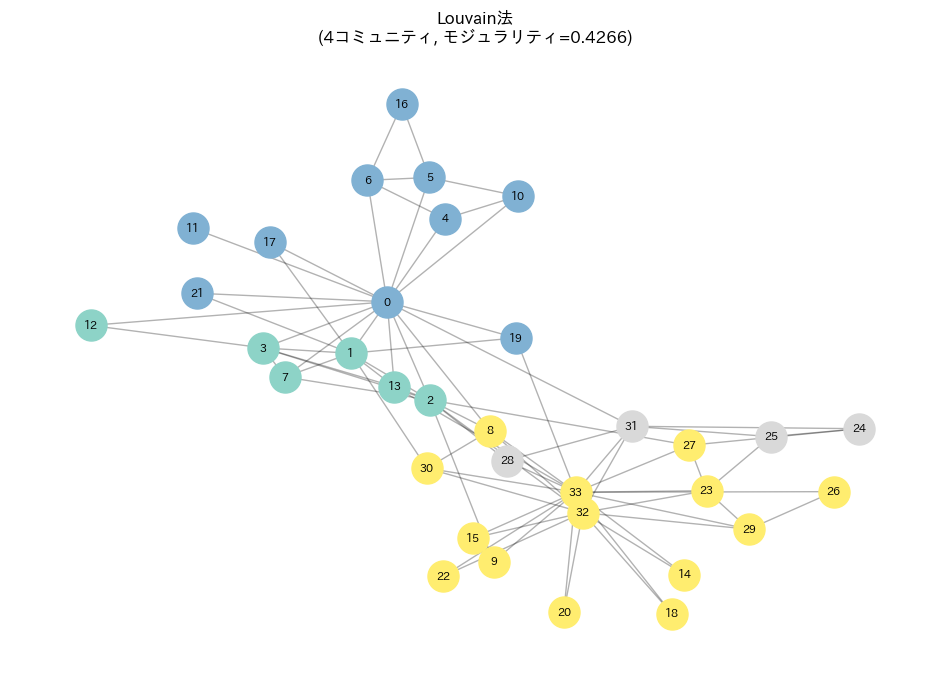

In [7]:
# 可視化
def visualize_communities(G, communities, title="コミュニティ検出結果"):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, seed=42)
    
    # コミュニティごとに色分け
    colors = plt.cm.Set3(np.linspace(0, 1, len(communities)))
    
    for i, comm in enumerate(communities):
        nx.draw_networkx_nodes(G, pos, nodelist=list(comm),
                              node_color=[colors[i]], node_size=500)
    
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    nx.draw_networkx_labels(G, pos, font_size=8)
    
    plt.title(f"{title}\n({len(communities)}コミュニティ, モジュラリティ={community.modularity(G, communities):.4f})")
    plt.axis('off')
    plt.show()

visualize_communities(G, communities_louvain, "Louvain法")

### 9.2.2 Greedy Modularity

=== Greedy Modularity ===
検出されたコミュニティ数: 3
  コミュニティ1: 17ノード
  コミュニティ2: 9ノード
  コミュニティ3: 8ノード


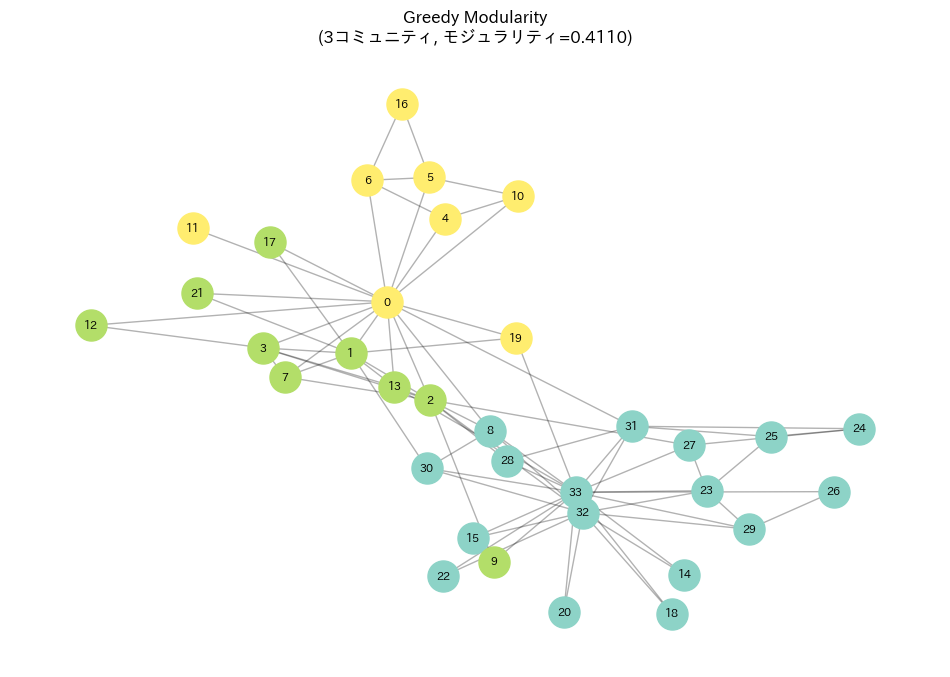

In [8]:
# Greedy Modularity Communities
communities_greedy = list(community.greedy_modularity_communities(G))

print(f"=== Greedy Modularity ===")
print(f"検出されたコミュニティ数: {len(communities_greedy)}")
for i, comm in enumerate(communities_greedy):
    print(f"  コミュニティ{i+1}: {len(comm)}ノード")

visualize_communities(G, communities_greedy, "Greedy Modularity")

### 9.2.3 Label Propagation

=== Label Propagation ===
検出されたコミュニティ数: 3


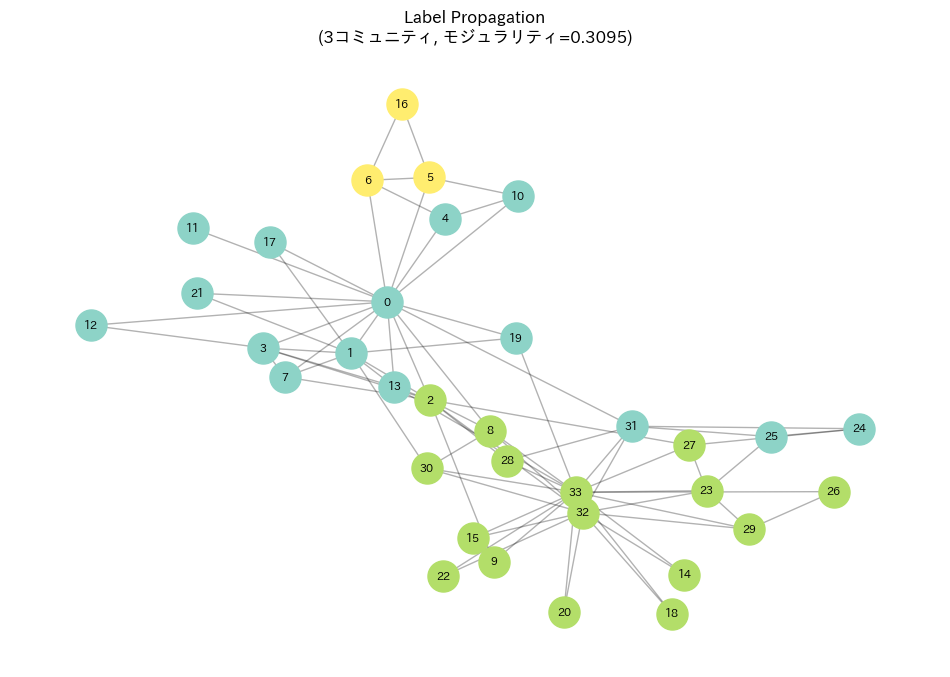

In [9]:
# Label Propagation
communities_label = list(community.label_propagation_communities(G))

print(f"=== Label Propagation ===")
print(f"検出されたコミュニティ数: {len(communities_label)}")

visualize_communities(G, communities_label, "Label Propagation")

### 9.2.4 Girvan-Newman法

In [10]:
# Girvan-Newman法（エッジ媒介中心性ベース）
gn = community.girvan_newman(G)

# 最初の数回の分割を取得
print("=== Girvan-Newman法（分割の履歴） ===")
for i in range(4):
    communities_gn = next(gn)
    mod = community.modularity(G, communities_gn)
    print(f"分割{i+1}: {len(communities_gn)}コミュニティ, モジュラリティ={mod:.4f}")

=== Girvan-Newman法（分割の履歴） ===
分割1: 2コミュニティ, モジュラリティ=0.3477
分割2: 3コミュニティ, モジュラリティ=0.3423
分割3: 4コミュニティ, モジュラリティ=0.3581
分割4: 5コミュニティ, モジュラリティ=0.3850


---
## 9.3 クリーク検出

クリーク = 完全に接続されたノード群

In [11]:
# すべてのクリークを取得
cliques = list(nx.find_cliques(G))

print(f"クリークの総数: {len(cliques)}")

# サイズ別にカウント
from collections import Counter
clique_sizes = Counter(len(c) for c in cliques)
print("\nサイズ別クリーク数:")
for size, count in sorted(clique_sizes.items()):
    print(f"  サイズ{size}: {count}個")

クリークの総数: 36

サイズ別クリーク数:
  サイズ2: 11個
  サイズ3: 21個
  サイズ4: 2個
  サイズ5: 2個


In [12]:
# 最大クリーク
max_clique = max(cliques, key=len)
print(f"\n最大クリーク: {sorted(max_clique)} (サイズ: {len(max_clique)})")


最大クリーク: [0, 1, 2, 3, 13] (サイズ: 5)


In [13]:
# k-クリーク コミュニティ
k_clique_communities = list(community.k_clique_communities(G, 4))
print(f"\n4-クリークコミュニティ数: {len(k_clique_communities)}")
for i, comm in enumerate(k_clique_communities):
    print(f"  コミュニティ{i+1}: {sorted(comm)}")


4-クリークコミュニティ数: 3
  コミュニティ1: [0, 1, 2, 3, 7, 13]
  コミュニティ2: [8, 30, 32, 33]
  コミュニティ3: [23, 29, 32, 33]


---
## 例題: 空手クラブの派閥分析

In [14]:
# 実際の派閥（ground truth）との比較
G = nx.karate_club_graph()

# 実際のクラブ分け
actual_communities = [
    set(n for n, d in G.nodes(data=True) if d['club'] == 'Mr. Hi'),
    set(n for n, d in G.nodes(data=True) if d['club'] == 'Officer')
]

print("=== 実際の派閥 ===")
print(f"Mr. Hi派: {sorted(actual_communities[0])}")
print(f"Officer派: {sorted(actual_communities[1])}")
print(f"モジュラリティ: {community.modularity(G, actual_communities):.4f}")

=== 実際の派閥 ===
Mr. Hi派: [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 16, 17, 19, 21]
Officer派: [9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
モジュラリティ: 0.3914


In [15]:
# アルゴリズムの結果と比較
detected = community.louvain_communities(G, seed=42)

# 一致度（NMI）の計算
def calculate_accuracy(detected, actual):
    """検出結果と実際の分類の一致度を計算"""
    # ノードごとのコミュニティ番号を取得
    detected_labels = {}
    for i, comm in enumerate(detected):
        for node in comm:
            detected_labels[node] = i
    
    actual_labels = {}
    for i, comm in enumerate(actual):
        for node in comm:
            actual_labels[node] = i
    
    # 一致するノードをカウント
    # （コミュニティの番号は対応が必要）
    correct = 0
    for node in G.nodes():
        # どちらのマッピングが正しいか確認
        pass
    
    return detected_labels, actual_labels

print("\n=== 検出結果との比較 ===")
for i, comm in enumerate(detected):
    mr_hi_count = len(comm & actual_communities[0])
    officer_count = len(comm & actual_communities[1])
    print(f"検出コミュニティ{i+1}: Mr.Hi={mr_hi_count}, Officer={officer_count}")


=== 検出結果との比較 ===
検出コミュニティ1: Mr.Hi=6, Officer=0
検出コミュニティ2: Mr.Hi=10, Officer=0
検出コミュニティ3: Mr.Hi=0, Officer=4
検出コミュニティ4: Mr.Hi=1, Officer=13


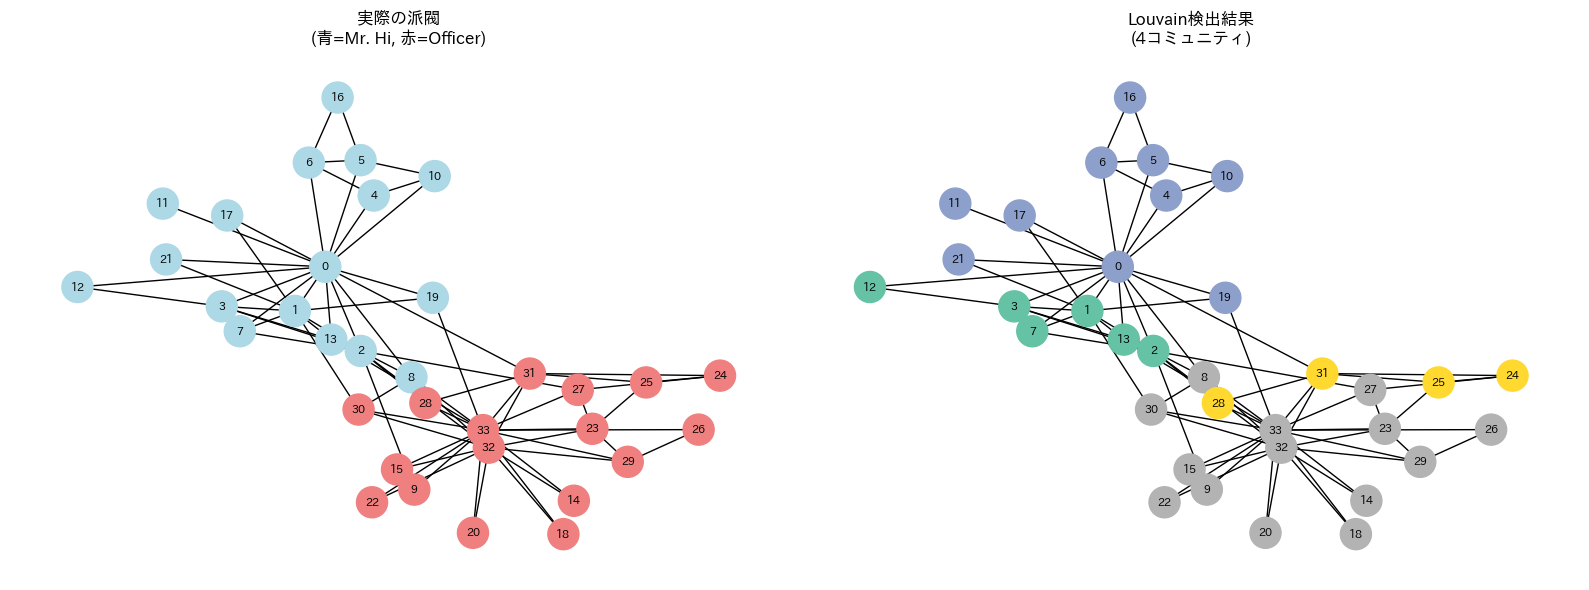

In [16]:
# 実際の派閥と検出結果を並べて可視化
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
pos = nx.spring_layout(G, seed=42)

# 実際の派閥
colors_actual = ['lightblue' if G.nodes[n]['club'] == 'Mr. Hi' else 'lightcoral' for n in G.nodes()]
nx.draw(G, pos, ax=axes[0], with_labels=True, node_color=colors_actual, node_size=500, font_size=8)
axes[0].set_title("実際の派閥\n(青=Mr. Hi, 赤=Officer)")

# Louvain検出結果
colors_detected = []
color_map = plt.cm.Set2(np.linspace(0, 1, len(detected)))
for node in G.nodes():
    for i, comm in enumerate(detected):
        if node in comm:
            colors_detected.append(color_map[i])
            break

nx.draw(G, pos, ax=axes[1], with_labels=True, node_color=colors_detected, node_size=500, font_size=8)
axes[1].set_title(f"Louvain検出結果\n({len(detected)}コミュニティ)")

plt.tight_layout()
plt.show()

---
## 練習問題

### 練習問題1: コミュニティ検出手法の比較

Stochastic Block Modelで生成したグラフに対して、複数のコミュニティ検出手法を適用し、モジュラリティで比較してください。

In [17]:
# ここにコードを記述してください



<details>
<summary>解答を見る</summary>

```python
# SBMグラフの生成（3コミュニティ）
sizes = [30, 30, 30]
p_matrix = [
    [0.5, 0.02, 0.02],
    [0.02, 0.5, 0.02],
    [0.02, 0.02, 0.5]
]
G = nx.stochastic_block_model(sizes, p_matrix, seed=42)

# 実際のコミュニティ
actual = [set(range(0, 30)), set(range(30, 60)), set(range(60, 90))]

# 各手法を適用
methods = {
    'Louvain': community.louvain_communities(G, seed=42),
    'Greedy Modularity': list(community.greedy_modularity_communities(G)),
    'Label Propagation': list(community.label_propagation_communities(G)),
}

print("=== コミュニティ検出手法の比較 ===")
print(f"{'手法':<20} {'コミュニティ数':>15} {'モジュラリティ':>15}")
print("-" * 55)

# 実際の値
actual_mod = community.modularity(G, actual)
print(f"{'実際の値':<20} {3:>15} {actual_mod:>15.4f}")

for name, comms in methods.items():
    mod = community.modularity(G, comms)
    print(f"{name:<20} {len(comms):>15} {mod:>15.4f}")

# 最良の手法
best_method = max(methods.items(), key=lambda x: community.modularity(G, x[1]))
print(f"\n最良の手法: {best_method[0]}")
```
</details>

---
## 9.4 章のまとめ

この章では以下を学びました：

1. **クラスタリング係数**: ノードの局所的な密度
2. **コミュニティ検出**:
   - Louvain法
   - Greedy Modularity
   - Label Propagation
   - Girvan-Newman法
3. **モジュラリティ**: コミュニティ分割の品質指標
4. **クリーク検出**: 完全部分グラフの発見

### 次章の予告
次章では、グラフの可視化について詳しく学びます。